<a href="https://colab.research.google.com/github/Neehan/Realtime_Rt/blob/master/Rt_dataprocessing_batch_better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the version of the code that does a batch run on all the districts of interest. For now it does it only using the new method, as the old method is somehow not converging well. 

Trying to organize the data management a bit better. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install arviz==0.11.0
!pip install pymc3==3.8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import theano.tensor as tt
from datetime import date
import os



     |████████████████████████████████| 1.6MB 5.2MB/s 
     |████████████████████████████████| 4.7MB 17.7MB/s 
     |████████████████████████████████| 768kB 49.6MB/s 
     |████████████████████████████████| 317kB 47.8MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
     |████████████████████████████████| 911kB 4.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


First, set up the code. Here is a function that computes everything. 

In [3]:

# disease parameters:
serial_interval = 7

# this is the total number (Mahi tells me its reasonable. Nothing really depends on this unless it evolves in time)
N = 50000

# define a function
def findRts(tests,deltaCases,dates):
  # this is a number choosing how many dates to offset by. 
  offset = 0;
  #deltaCases = deltaCases[offset:]
  #tests = tests[offset:]
  startDate = dates[offset]

  positivity = deltaCases/tests;
  # shift them forward by 1.

  deltaCases_future = deltaCases[1:];
  deltaCases_past = deltaCases[:-1]

  # make a plot of the positivity ratio 
  #plt.plot(positivity)
  #plt.xlabel("Day")
  #plt.ylabel("Measured positivity")

  # this is the new one. 
  Rt_model = pm.Model()


  # okay this is the dynamics of the infection rate. each day is given by a Poisson distribution
  # of the day before (...except not, because I use the Gaussian approximation to Poisson: the numbers
  # are high enough that it doesn't matter, and it seems NUTS > Metropolis)

  class PoissonWalk(pm.Continuous):
    def __init__(self,Rt,*args,**kwargs):
      super().__init__(*args,**kwargs)
      self.Rt = tt.as_tensor_variable(Rt)
      #self.mode=tt.as_tensor_variable(1.0)

    # I don't think this is necessary? 
    def random(self, point=None, size=None):
      raise NotImplementedError("Haven't implemented this yet")
    
    def logp(self,x):
      Rt = self.Rt
      x_im1 = x[:-1]
      x_i = x[1:]
      # I'm using a continuous distribution because they are better for NUTS-ing
      # the mean and the variance of this thing are the same (its the Gaussian limit of the Poisson)
      innov_like = pm.Normal.dist(mu=x_im1*pm.math.exp((Rt[:-1]-1)/serial_interval),sigma=pm.math.sqrt(x_im1*pm.math.exp((Rt[:-1]-1)/serial_interval))).logp(x_i)
      return tt.sum(innov_like)

  # okay, now try build the model
  with Rt_model:
    # Give Rt the prior that it is a random walk with Gaussian deviations
    sigma = pm.Exponential('sigma',1/0.02)
    Rt = pm.GaussianRandomWalk('Rt',sigma=sigma,shape=len(deltaCases))

    # put in the quasi-deterministic behavior of It
    # I think this goes bad if there are every zero cases; let me fix this
    safeInit = deltaCases;
    safeInit[safeInit==0] = 1;

    It = PoissonWalk('It',Rt=Rt,shape=len(deltaCases),testval=safeInit)
    # I initialize it on the number of actual cases, this isnt important as it finds its own way.

    # next, a distribution on the number of observed cases (there is no hypergeometric in pymc3! using binomial instead)
    Pt = pm.Binomial('Pt',n=tests,p=It/N,observed = deltaCases)


  with Rt_model:
    trace=pm.sample(4000,tune=1000)
    #trace = pm.sample(5,tune=5)
    #pm.traceplot(trace,varnames=['sigma'])
    #pm.summary(trace,varnames=['Rt'])

  
  # finally make the version of the plot that is output
  plt.figure()
  hdis = az.hdi(trace['Rt'],hdi_prob=0.9)
  #plt.plot(hdis,'C2')
  #plt.plot(hdis[:,1])
  plt.plot(np.mean(trace['Rt'],axis=0),'k')
  plt.plot(np.ones(len(deltaCases)),'r')
  plt.fill_between(range(len(deltaCases)),hdis[:,0],hdis[:,1],alpha=0.2)
  plt.xlabel('Days since ' + startDate)
  plt.ylabel('R(t)')
  plt.title('R(t) ' + d + ' (corrected for testing levels)')
  plt.annotate('Generated on ' + date.today().strftime("%Y-%m-%d"),xy=(5, 5),xycoords='figure points',style='italic',fontsize='7')
  # okay, now save the values
  plt.savefig(folder + '/' + d + '.png')
  plt.show()

  Rtfinal = np.mean(trace['Rt'],axis=0)[-1];
  hdi_low = hdis[-1,0];
  hdi_high = hdis[-1,1];
  doubling_rate = (serial_interval * np.log(2))/(Rtfinal-1)

  return (Rtfinal, hdi_low, hdi_high,doubling_rate);




In [4]:

# read the data:
#data=pd.read_csv('./drive/My Drive/Rt tracker/Output files/a2i data exchange/input/a2i_data.csv')

date_today = date.today().strftime('%Y-%m-%d')
data = pd.read_csv(f'http://cdr.a2i.gov.bd/positive_case_data/{date_today}.csv')
data['district'] = data['district'].str.title()

# okay, first extract a list of district names
all_districts = data['district']
districts = [];

for d in all_districts:
  if (d not in districts and isinstance(d,str)):
    districts.append(d);

# now we have a list of unique districts
print(districts)

# however they actually want a list of high-risk districts, get that first
highrisk_data=pd.read_csv('./drive/My Drive/Rt tracker/Data/ThirdWave/high_risk.csv');
highrisk_districts = highrisk_data['District'].to_list()

# create some things to hold everything

all_Rts = [];
all_hdis_low = [];
all_hdis_high = [];
all_doublings = [];

#print(highrisk_districts)

districts_todo = ['National','National except CTG DHK','Chattogram','Dhaka','Khulna','Rajshahi']
#districts_todo = ['Chattogram','Dhaka','Khulna','Rajshahi']

['Barguna', 'Barishal', 'Patuakhali', 'Pirojpur', 'Chattogram', 'Dinajpur', 'Narayanganj', 'Natore', 'Dhaka', 'Pabna', 'Noakhali', 'Naogaon', 'Thakurgaon', 'Gazipur', 'Sirajganj', 'Bogura', 'Bhola', 'Chuadanga', 'Jhalokati', 'Meherpur', 'Rajbari', 'Gaibandha', 'Sylhet', 'Faridpur', 'Gopalganj', 'Magura', 'Narsingdi', 'Panchagarh', 'Coxs Bazar', 'Jamalpur', 'Kishoreganj', 'Moulvibazar', 'Mymensingh', 'Netrakona', 'Rajshahi', 'Sunamganj', 'Tangail', 'Chandpur', 'Cumilla', 'Sherpur', 'Kurigram', 'Madaripur', 'Rangpur', 'Satkhira', 'Bandarban', 'Brahmanbaria', 'Habiganj', 'Kushtia', 'Lalmonirhat', 'Manikganj', 'Nilphamari', 'Shariatpur', 'Bagerhat', 'Jashore', 'Khulna', 'Feni', 'Lakshmipur', 'Munshiganj', 'Narail', 'Jhenaidah', 'Chapainababganj', 'Joypurhat', 'Khagrachhari', 'Rangamati']


In [5]:
# some small data management subroutines 

#offset = -85;
#offset = 0;

offset = -80;

def findNational():
  # adds up everything (skips any districts with missing data, this is a bit dangerous)
  data_DHK = data[data['district']=='Dhaka'];
  dates = data_DHK['test_date'][offset:].to_list();
  tests = np.zeros(len(dates));
  deltaCases = np.zeros(len(dates));

  for district in districts:
    #print("On district " + district);
    data_d = data[data['district']==district];
    if (len(data_d['tests_nontraveller'][offset:]) == len(dates)): 
      tests=tests+np.array(np.floor(data_d['tests_nontraveller'].rolling(window=7).mean()))[offset:];
      deltaCases = deltaCases+np.array(np.floor(data_d['cases_nontraveller'].rolling(window=7).mean()))[offset:];
    else:
      print('Skipping '+ district + 'due to missing dates.')

  return(tests,deltaCases,dates);

def findNationalExceptDHKCTG():
  # adds up everything (skips any districts with missing data, this is a bit dangerous) 
  data_DHK = data[data['district']=='Dhaka'];
  dates = data_DHK['test_date'][offset:].to_list();
  tests = np.zeros(len(dates));
  deltaCases = np.zeros(len(dates));
  
  for district in districts:
    #print("On district " + district);
    data_d = data[data['district']==district];
    if (district != 'Dhaka' and district != 'Chattogram'):
      if (len(data_d['tests_nontraveller'][offset:]) == len(dates)): 
        tests=tests+np.array(np.floor(data_d['tests_nontraveller'].rolling(window=7).mean()))[offset:];
        deltaCases = deltaCases+np.array(np.floor(data_d['cases_nontraveller'].rolling(window=7).mean()))[offset:];
      else:
        print('Skipping '+ district + 'due to missing dates.')

  return(tests,deltaCases,dates);

def findDistrict(district):
  data_d = data[data['district']==district];
  dates = data_d['test_date'][offset:].to_list();
  tests=np.array(np.floor(data_d['tests_nontraveller'].rolling(window=7).mean()))[offset:];
  deltaCases = np.array(np.floor(data_d['cases_nontraveller'].rolling(window=7).mean()))[offset:];
  return(tests,deltaCases,dates);

Currently on National


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [It, Rt, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 5000/5000 [00:50<00:00, 99.32it/s] 
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


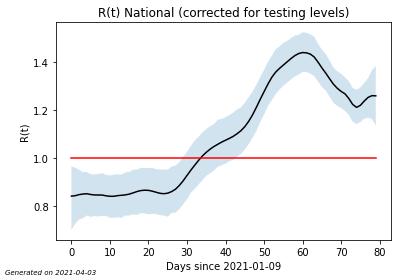

Currently on National except CTG DHK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [It, Rt, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 5000/5000 [01:10<00:00, 70.54it/s]
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


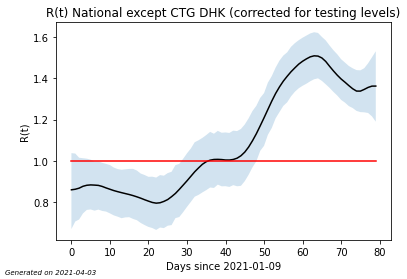

Currently on Chattogram


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [It, Rt, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 5000/5000 [01:59<00:00, 41.96it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


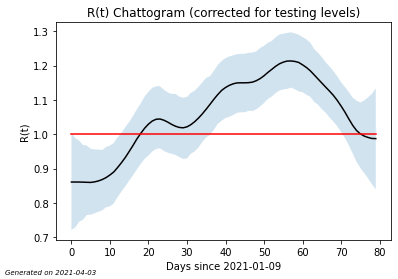

Currently on Dhaka


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [It, Rt, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 5000/5000 [01:06<00:00, 75.16it/s]
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


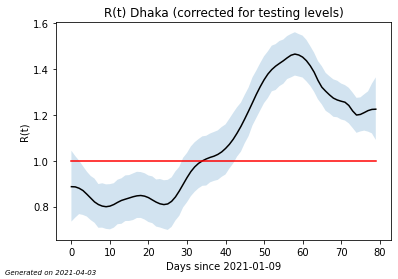

Currently on Khulna


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [It, Rt, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 5000/5000 [07:49<00:00, 10.66it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


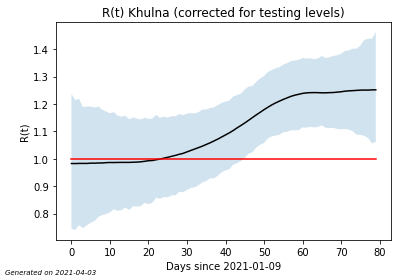

Currently on Rajshahi


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [It, Rt, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 5000/5000 [03:38<00:00, 22.91it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


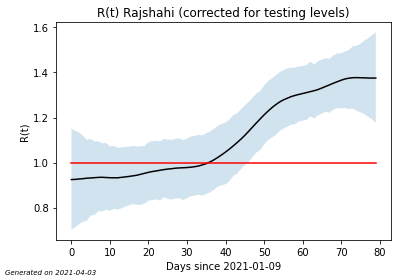

In [6]:
# okay, now time to go through them all
for d in districts_todo:
  #d = 'Chattogram';
  print('Currently on '+d);

  # make the directory if not yet ready
  folder = './drive/My Drive/Rt tracker/Output files/a2i data exchange/output/'+date.today().strftime("%Y-%m-%d");

  if (not os.path.isdir(folder)):
    os.mkdir(folder);
  
  # import the data
  if (d == 'National'):
    (tests,deltaCases,dates) = findNational();
  elif (d == 'National except CTG DHK'):
    (tests,deltaCases,dates) = findNationalExceptDHKCTG();
  else:
    (tests,deltaCases,dates) = findDistrict(d);

  # check that this works
  (Rtfinal,hdi_low,hdi_high,doubling_rate) = findRts(tests,deltaCases,dates);

  all_Rts.append(Rtfinal);
  all_hdis_low.append(hdi_low);
  all_hdis_high.append(hdi_high);
  all_doublings.append(doubling_rate);

  # okay, now its all over --- save the output to a CSV file; do this in the loop rather than at the end so that we can see it as we go. 
  df = pd.DataFrame(list(zip(districts_todo, all_Rts,all_hdis_low,all_hdis_high,all_doublings)),
                columns =['District name', 'R(t)','HDI low','HDI high','Doubling time']);
  df.to_csv(folder+'/'+date.today().strftime("%Y-%m-%d")+'-summary.csv');



In [7]:
(testsC,casesC,datesC)=findDistrict('Chattogram')
(testsD,casesD,datesD)=findDistrict('Dhaka')
(tests,cases,dates)=findNational()
(testsX,casesX,dates) = findNationalExceptDHKCTG()

casesX + casesC + casesD - cases
testsX + testsC + testsD - tests

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
districts

['Barguna',
 'Barishal',
 'Patuakhali',
 'Pirojpur',
 'Chattogram',
 'Dinajpur',
 'Narayanganj',
 'Natore',
 'Dhaka',
 'Pabna',
 'Noakhali',
 'Naogaon',
 'Thakurgaon',
 'Gazipur',
 'Sirajganj',
 'Bogura',
 'Bhola',
 'Chuadanga',
 'Jhalokati',
 'Meherpur',
 'Rajbari',
 'Gaibandha',
 'Sylhet',
 'Faridpur',
 'Gopalganj',
 'Magura',
 'Narsingdi',
 'Panchagarh',
 'Coxs Bazar',
 'Jamalpur',
 'Kishoreganj',
 'Moulvibazar',
 'Mymensingh',
 'Netrakona',
 'Rajshahi',
 'Sunamganj',
 'Tangail',
 'Chandpur',
 'Cumilla',
 'Sherpur',
 'Kurigram',
 'Madaripur',
 'Rangpur',
 'Satkhira',
 'Bandarban',
 'Brahmanbaria',
 'Habiganj',
 'Kushtia',
 'Lalmonirhat',
 'Manikganj',
 'Nilphamari',
 'Shariatpur',
 'Bagerhat',
 'Jashore',
 'Khulna',
 'Feni',
 'Lakshmipur',
 'Munshiganj',
 'Narail',
 'Jhenaidah',
 'Chapainababganj',
 'Joypurhat',
 'Khagrachhari',
 'Rangamati']

In [9]:
districts

['Barguna',
 'Barishal',
 'Patuakhali',
 'Pirojpur',
 'Chattogram',
 'Dinajpur',
 'Narayanganj',
 'Natore',
 'Dhaka',
 'Pabna',
 'Noakhali',
 'Naogaon',
 'Thakurgaon',
 'Gazipur',
 'Sirajganj',
 'Bogura',
 'Bhola',
 'Chuadanga',
 'Jhalokati',
 'Meherpur',
 'Rajbari',
 'Gaibandha',
 'Sylhet',
 'Faridpur',
 'Gopalganj',
 'Magura',
 'Narsingdi',
 'Panchagarh',
 'Coxs Bazar',
 'Jamalpur',
 'Kishoreganj',
 'Moulvibazar',
 'Mymensingh',
 'Netrakona',
 'Rajshahi',
 'Sunamganj',
 'Tangail',
 'Chandpur',
 'Cumilla',
 'Sherpur',
 'Kurigram',
 'Madaripur',
 'Rangpur',
 'Satkhira',
 'Bandarban',
 'Brahmanbaria',
 'Habiganj',
 'Kushtia',
 'Lalmonirhat',
 'Manikganj',
 'Nilphamari',
 'Shariatpur',
 'Bagerhat',
 'Jashore',
 'Khulna',
 'Feni',
 'Lakshmipur',
 'Munshiganj',
 'Narail',
 'Jhenaidah',
 'Chapainababganj',
 'Joypurhat',
 'Khagrachhari',
 'Rangamati']

In [10]:
len(districts)

64

In [11]:
data['district'] = data['district'].str.title()

In [12]:
len(districts)

64

In [13]:
data['district'].str.title()

0           Barguna
1          Barishal
2        Patuakhali
3          Pirojpur
4        Chattogram
            ...    
21718     Sirajganj
21719     Sunamganj
21720        Sylhet
21721       Tangail
21722    Thakurgaon
Name: district, Length: 21723, dtype: object

In [14]:
len(districts)

64

In [15]:
findNational()

(array([ 6565.,  6686.,  6615.,  6786.,  6739.,  6677.,  6795.,  6861.,
         6813.,  6823.,  6779.,  6818.,  6827.,  6696.,  6574.,  6553.,
         6495.,  6352.,  6185.,  5874.,  5835.,  5676.,  5562.,  5627.,
         5655.,  5683.,  5952.,  5952.,  6029.,  6023.,  5863.,  5792.,
         5704.,  5498.,  5471.,  5470.,  5424.,  5406.,  5461.,  5382.,
         5377.,  5222.,  5228.,  5013.,  4758.,  4642.,  4711.,  4784.,
         4903.,  4778.,  5003.,  5319.,  5413.,  5433.,  5312.,  5239.,
         5373.,  5497.,  5510.,  5507.,  5597.,  5760.,  5898.,  6022.,
         6275.,  6599.,  7142.,  7289.,  7462.,  7824.,  8112.,  8313.,
         8776.,  8886.,  9366., 10365., 10746., 11173., 11403., 11239.]),
 array([ 617.,  608.,  580.,  584.,  569.,  574.,  561.,  542.,  527.,
         533.,  514.,  498.,  477.,  469.,  454.,  437.,  417.,  401.,
         384.,  362.,  350.,  343.,  333.,  326.,  321.,  311.,  318.,
         309.,  298.,  290.,  281.,  270.,  271.,  259.,  260.,  

In [16]:
findNational();